<span style="color:#1976d2; font-size:2.2em; font-weight:bold;">🔥 Projet London Fire Response</span>

<span style="color:#42a5f5; font-size:2em; font-weight:bold;">Exploration des données</span>

Ce notebook a pour but de charger, assembler et analyser rapidement les données brutes provenant de deux sources :

-les incidents signalés : https://data.london.gov.uk/dataset/london-fire-brigade-incident-records

-les mobilisations des pompiers: https://data.london.gov.uk/dataset/london-fire-brigade-mobilisation-records

<span style="color:#e91e63; font-size:1em; font-weight:bold;">1. Import des bibliothèques Python</span>

In [1]:
import os                # Pour manipuler les chemins de fichiers
import pandas as pd      # Pour charger et analyser les données
import glob              # Pour lister automatiquement tous les fichiers d’un dossier
import matplotlib.pyplot as plt  # Visualisation
import seaborn as sns             # Visualisation statistique

In [2]:
# Pour afficher toutes les colonnes et tout explorer !
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

  <span style="color:#e91e63; font-size:1em; font-weight:bold;">2. Définition les chemins propres</span>

In [4]:
# Revenir au dossier parent
base_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))

# Dossiers contenant les fichiers incidents et mobilisations
incidents_path = os.path.join(base_path, "data", "raw", "incidents")
mobilisations_path = os.path.join(base_path, "data", "raw", "mobilisations")

# Vérifier que les chemins existent
print("Répertoire courant :", os.getcwd())
print("-Chemin incidents :", incidents_path)
print("-Chemin mobilisations :", mobilisations_path)

# Fonction pour lister les fichiers dans les dossiers incidents et mobilisations
def lister_fichiers(dossier):
    if os.path.exists(dossier):
        fichiers = os.listdir(dossier)
        if fichiers:
            print(f"\nFichiers dans {dossier} :")
            for f in fichiers:
                print("   -", f)
        else:
            print(f"\nLe dossier {dossier} est vide.")
    else:
        print(f"\nLe chemin {dossier} n'existe pas.")

# Lister les fichiers dans incidents et mobilisations
lister_fichiers(incidents_path)
lister_fichiers(mobilisations_path)

Répertoire courant : c:\Users\9609241C\london-fire-response\notebooks\exploration
-Chemin incidents : c:\Users\9609241C\london-fire-response\data\raw\incidents
-Chemin mobilisations : c:\Users\9609241C\london-fire-response\data\raw\mobilisations

Fichiers dans c:\Users\9609241C\london-fire-response\data\raw\incidents :
   - incidents_2009_2017.csv
   - Incidents_2018_2025.csv

Fichiers dans c:\Users\9609241C\london-fire-response\data\raw\mobilisations :
   - mobilisations_2009_2014.xlsx
   - mobilisations_2015_2020.xlsx
   - mobilisations_2021_2024.csv
   - mobilisations_2025.xlsx


<span style="color:#e91e63; font-size:1em; font-weight:bold;">3. Charger tous les fichiers incidents (.csv)  </span>

In [5]:
incident_files = glob.glob(os.path.join(incidents_path, "*.csv"))

# On charge tous les fichiers et on les regroupe
incidents = pd.concat([pd.read_csv(f) for f in incident_files], ignore_index=True)

# Aperçu rapide des données
print("Données incidents chargées !")
print(incidents.head())
print("-Nombre de lignes :", len(incidents))
print("-Nombre de colonnes :", len(incidents.columns))
print("-Colonnes :", incidents.columns.tolist())
print("-Types de données :", incidents.dtypes)

C:\Users\9609241C\AppData\Local\Temp\ipykernel_23216\1313176135.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  incidents = pd.concat([pd.read_csv(f) for f in incident_files], ignore_index=True)


Données incidents chargées !
  IncidentNumber DateOfCall  CalYear TimeOfCall  HourOfCall    IncidentGroup  \
0    235138081.0  01-Jan-09     2009   00:00:37           0  Special Service   
1         1091.0  01-Jan-09     2009   00:00:46           0  Special Service   
2         2091.0  01-Jan-09     2009   00:03:00           0             Fire   
3         3091.0  01-Jan-09     2009   00:04:27           0             Fire   
4         5091.0  01-Jan-09     2009   00:05:39           0             Fire   

  StopCodeDescription     SpecialServiceType PropertyCategory  \
0     Special Service                    RTC     Road Vehicle   
1     Special Service  Assist other agencies          Outdoor   
2      Secondary Fire                    NaN          Outdoor   
3      Secondary Fire                    NaN          Outdoor   
4      Secondary Fire                    NaN          Outdoor   

                                  PropertyType  \
0                                         Car    

In [6]:
#Vérifier la période des données d'incidents : doit etre de 2009 à 2025
print("Période des données d'incidents chargées: De", min(incidents["CalYear"]), "à", max(incidents["CalYear"]))

Période des données d'incidents chargées: De 2009 à 2025


<span style=" font-weight:bold; font-size:1em; color:#2d8563 "> 📊 Observations de l'importation et exploration initiale des données `incidents` </span>
<span style=" font-size:0.5em;">
* Les données ont bien été chargées (environ 1,8 million de lignes, 39 colonnes).
* Avertissement sur `IncidentNumber` : mélange de types (probablement des entiers et des chaînes de caracteres).
* Beaucoup de colonnes sont de type texte (`object`), avec aussi des numériques (`int64`, `float64`), notamment pour les coûts, le nombre de pompes, les temps d’intervention, etc.
* Il y a plusieurs colonnes temporelles redondantes (`DateOfCall`, `TimeOfCall`, `HourOfCall`, `CalYear`) → possibilité de les combiner à voir !.
* Les colonnes liées à la localisation sont riches : code postal, latitude/longitude, boroughs, wards…
* On observe des valeurs manquantes dans certaines colonnes (`UPRN`, `USRN`, `SecondPump...`).
* Quelques colonnes semblent redondantes ou doublées (`IncGeo_WardName` vs `IncGeo_WardNameNew`, `FRS` vs `ProperCase`).
* Il faudra convertir les dates en datetime, harmoniser les types, et potentiellement nettoyer les colonnes peu remplies ou inutiles. </span>

<span style="color:#e91e63; font-size:1em; font-weight:bold;">4. Charger tous les fichiers mobilisations (.csv ou .xlsx) </span>

In [7]:
# Fichiers .csv et .xlsx
mobilisation_csv = glob.glob(os.path.join(mobilisations_path, "*.csv"))
mobilisation_xlsx = glob.glob(os.path.join(mobilisations_path, "*.xlsx"))

# Charger tout et regrouper
mobilisations = pd.concat(
    [pd.read_csv(f) for f in mobilisation_csv] + 
    [pd.read_excel(f) for f in mobilisation_xlsx],
    ignore_index=True
)

# Aperçu rapide des données mobilisations
print(" Données mobilisations chargées !")
print(mobilisations.head())

C:\Users\9609241C\AppData\Local\Temp\ipykernel_23216\2679582708.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mobilisations = pd.concat(


 Données mobilisations chargées !
    IncidentNumber  CalYear           BoroughName      WardName  HourOfCall  \
0  000004-01012021     2021              HARINGEY  Muswell Hill           0   
1  000005-01012021     2021             REDBRIDGE      MONKHAMS           0   
2  000006-01012021     2021  BARKING AND DAGENHAM       Village           0   
3  000007-01012021     2021            WANDSWORTH     West Hill           0   
4  000007-01012021     2021            WANDSWORTH     West Hill           0   

   ResourceMobilisationId Resource_Code PerformanceReporting  \
0                 5769249          A321                    1   
1                 5769250          F351                    1   
2                 5769251          F412                    1   
3                 5769252          H331                    1   
4                 5769253          G351                    2   

  DateAndTimeMobilised DateAndTimeMobile DateAndTimeArrived  \
0     01/01/2021 00:06  01/01/2021 00:07   

In [8]:
#Vérifier la période des données de mobilisations: doit etre de 2009 à 2025
print("Période des données de mobilisations chargées: De", min(mobilisations["CalYear"]), "à", max(mobilisations["CalYear"]))

Période des données de mobilisations chargées: De 2009 à 2025


In [9]:
#Suite exploration mobilisations
print("-Nombre de lignes :", len(mobilisations))
print("-Nombre de colonnes :", len(mobilisations.columns))
print("-Colonnes :", mobilisations.columns.tolist())
print("-Types de données :", mobilisations.dtypes)

-Nombre de lignes : 2561435
-Nombre de colonnes : 24
-Colonnes : ['IncidentNumber', 'CalYear', 'BoroughName', 'WardName', 'HourOfCall', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code', 'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description']
-Types de données : IncidentNumber                      object
CalYear                              int64
BoroughName                         object
WardName                            object
HourOfCall                           int64
ResourceMobilisationId               int64
Resource_Code                       object
PerformanceReporting                object
DateAndTimeMobilised                object
DateAndTimeMobile                   obj

<span style=" font-weight:bold; font-size:1em; color:#2d8563 "> 📊 Observations de l'importation et exploration initiale des données `mobilisations` </span>
<span style="font-size:0.5em ">
- d'apres le warning du chargement avec pd : présence de colonnes vides ou très mal renseignées dans certains fichiers du dataset.
-`DelayCode_Description` contient beaucoup de valeurs manquantes
- Faudra faire attention à la conversion des `IncidentNumber` notamment pr le join entre les 2 datasets !
- Les 4 colonnes temporelles 'DateAndTimeMobilised','DateAndTimeMobile' ,'DateAndTimeArrived' ,'DateAndTimeLeft': ont un format cohérent nécessitent un to_datetime().

IncidentNumber : etant  l'identifiant de l'incident
PumpOrder : ordre d’arrivée de l’engin 
ApplianceIdentifier / ApplianceCallSign : identifiants du véhicule
==> Plusieurs mobilisations sont donc liées à un même incident, ce qui créera des doublons d’incidents mais lignes uniques de mobilisation.

Pour ce qui des données de Localisation :
BoroughCode / BoroughName, DeployedFromStation_Code / DeployedFromStation_Name, StationGround
==> Les données  semblentmajoritairement complètes sur la géographie, avec des noms lisibles. Peu de valeurs nulles.
</span>

<span style="color:#e91e63; font-size:1em; font-weight:bold;">5. Jointure entre les data incidents et mobilisations </span>

In [10]:
# 1. Vérifier Contenu + ordre strictement identiques (en réinitialisant les index)
(set(incidents['IncidentNumber'].reset_index(drop=True)) != set(mobilisations['IncidentNumber'].reset_index(drop=True)))

True

In [11]:
#2. Vérifier que les ensembles de valeurs sont identiques (contenu, peu importe l’ordre)
set(incidents['IncidentNumber']) == set(mobilisations['IncidentNumber'])

False

In [12]:
#3. Vérifier que les deux DataFrames ont le même nombre de lignes
len(incidents) == len(mobilisations)

False

In [13]:
#4. Identifier les différences entre les deux colonnes
#-a. Valeurs présentes dans incidents mais pas dans mobilisations 
set(incidents['IncidentNumber']) - set(mobilisations['IncidentNumber'])

{'143912151.00',
 '120456-10082023',
 '146061151.00',
 58458121.0,
 214958091.0,
 149422091.0,
 '129199151.00',
 20185101.0,
 23855121.0,
 '032414-06032022',
 18350101.0,
 54788121.0,
 '004528-11012019',
 114819101.0,
 125829151.0,
 85721121.0,
 '132689151.00',
 '023677-25022018',
 145752111.0,
 '176336-17122018',
 51118131.0,
 76546101.0,
 78381111.0,
 '072606-15062020',
 '129499-05082024',
 38273091.0,
 18350151.0,
 '140192-02102018',
 '088978-10072019',
 '167676-04122015',
 '140507-15102019',
 '056981-11042024',
 '147606-30102019',
 41943121.0,
 9175121.0,
 140247121.0,
 '141028151.00',
 '007450-12012025',
 '025438-19022022',
 3670101.0,
 41943131.0,
 140247131.0,
 '118636-03092019',
 '047795-21042019',
 '066004-11052023',
 196608091.0,
 98304101.0,
 65536101.0,
 1835111.0,
 160170091.0,
 169345131.0,
 29098091.0,
 107479151.0,
 '108829-05072024',
 132907121.0,
 '151329151.00',
 158335091.0,
 30933111.0,
 '058901-12052018',
 98304121.0,
 100139131.0,
 '136876151.00',
 63701121.0,
 1

In [14]:
#b. Valeurs présentes dans mobilisations mais pas dans incidents 
set(mobilisations['IncidentNumber']) - set(incidents['IncidentNumber'])

{52953091,
 147718151,
 131334151,
 145883151,
 '107228-13082021',
 173146141,
 51118111,
 '058821-10052017',
 142213151,
 '195981-19112024',
 140378151,
 '003859-06012025',
 '219973-28122024',
 153092151,
 151257151,
 134873151,
 162136131,
 149422151,
 133038151,
 '020914-19022017',
 '022464-23022018',
 20054101,
 '007051-11012025',
 143917151,
 '164080-04122019',
 142082151,
 '057123-15052021',
 '003762-09012017',
 '139918-17102021',
 152961151,
 136577151,
 '004702-11012017',
 151126151,
 149291151,
 131072151,
 145621151,
 129237151,
 143786151,
 '018114-15022021',
 '220948-29122024',
 '036100-22032018',
 107348141,
 141951151,
 140116151,
 '086056-15062022',
 138281151,
 152830151,
 '017056-10022017',
 149160151,
 '137980-19082024',
 129106151,
 141820151,
 '214267-18122024',
 77988101,
 152699151,
 134480151,
 150864151,
 147194151,
 '197857-16122023',
 128975151,
 '063278-20052017',
 36045121,
 139854151,
 '171495-23122017',
 '108584-17072022',
 152568151,
 '096072-24072016',
 

la colonne IncidentNumber n'étant pas identique dans les deux tables : celà justifie la perte de donnée lorsque la jointure à été faite dessus 
=>  changement de l'index pour la jointure !
CalYear présente dans les deux tables : on vérifie la jointure dessus au préalable:

In [14]:
print(incidents.columns)
print(mobilisations.columns)

# 1. Conversion au type int
incidents['CalYear'] = pd.to_numeric(incidents['CalYear'], errors='coerce').astype('Int64')
mobilisations['CalYear'] = pd.to_numeric(mobilisations['CalYear'], errors='coerce').astype('Int64')

# 2. Vérification des valeurs nulles
print("Valeurs nulles incidents CalYear:", incidents['CalYear'].isnull().sum())
print("Valeurs nulles mobilisations CalYear:", mobilisations['CalYear'].isnull().sum())

# 3. Valeurs uniques et distribution 
print("Valeurs uniques incidents CalYear:", incidents['CalYear'].unique())
print("Valeurs uniques mobilisations CalYear:", mobilisations['CalYear'].unique())

print("Répartition par année dans incidents :")
print(incidents['CalYear'].value_counts())

print("Répartition par année dans mobilisations :")
print(mobilisations['CalYear'].value_counts())

#  4. Comparaison des années entre les deux datasets 
set_incidents_years = set(incidents['CalYear'].dropna())
set_mobilisations_years = set(mobilisations['CalYear'].dropna())

print("Années dans incidents mais pas dans mobilisations :", set_incidents_years - set_mobilisations_years)
print("Années dans mobilisations mais pas dans incidents :", set_mobilisations_years - set_incidents_years)

# 5. Vérification des doublons (pour savoir si jointure 1-1 possible) 
print("Doublons dans incidents sur CalYear :", incidents['CalYear'].duplicated().sum())
print("Doublons dans mobilisations sur CalYear :", mobilisations['CalYear'].duplicated().sum())

#  6. Test rapide de jointure 
test_join = incidents.merge(mobilisations, on='CalYear', how='inner')
print("Résultat jointure (5 premières lignes) :")
print(test_join.head())
print("Nombre de lignes après jointure :", len(test_join))


Index(['IncidentNumber', 'DateOfCall', 'CalYear', 'TimeOfCall', 'HourOfCall',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS',
       'IncidentStationGround', 'FirstPumpArriving_AttendanceTime',
       'FirstPumpArriving_DeployedFromStation',
       'SecondPumpArriving_AttendanceTime',
       'SecondPumpArriving_DeployedFromStation',
       'NumStationsWithPumpsAttending', 'NumPumpsAttending', 'PumpCount',
       'PumpMinutesRounded', 'Notional Cost (£)', 'NumCalls'],
      dtype='object')
Index(['IncidentNumber', 'CalYear', 'BoroughName', 'WardName', 'HourOfCall',
       'ResourceMobilisationId', 'Resource_Code

MemoryError: Unable to allocate 2.09 TiB for an array with shape (286727310390,) and data type int64

CalYear seul produit une jointure massive (explosion mémoire) car très faible cardinalité ==> à combiner avec une autre ou en choisir une autre:

In [ ]:
# Convertir les colonnes de date 
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], dayfirst=True)
mobilisations['DateAndTimeMobilised'] = pd.to_datetime(mobilisations['DateAndTimeMobilised'], dayfirst=True)

# Extraire la date et l’heure
incidents['DateOnly'] = incidents['DateOfCall'].dt.date
mobilisations['DateOnly'] = mobilisations['DateAndTimeMobilised'].dt.date
mobilisations['HourMobilised'] = mobilisations['DateAndTimeMobilised'].dt.hour

# S'assurer que l'heure est bien en int
incidents['HourOfCall'] = incidents['HourOfCall'].astype(int)
mobilisations['HourMobilised'] = mobilisations['HourMobilised'].astype(int)

# Créer les clés sous forme de tuples (CalYear, DateOnly, Hour)
keys_incidents = set(zip(incidents['CalYear'], incidents['DateOnly'], incidents['HourOfCall']))
keys_mobilisations = set(zip(mobilisations['CalYear'], mobilisations['DateOnly'], mobilisations['HourMobilised']))

# Comparaison détaillée
print(f"Nombre total de clés incidents       : {len(keys_incidents)}")
print(f"Nombre total de clés mobilisations   : {len(keys_mobilisations)}")

if keys_incidents == keys_mobilisations:
    print("Les ensembles de clés sont identiques. La jointure se fera parfaitement.")
else:
    print("Les ensembles de clés sont différents. Attention à la jointure.")
    
    common_keys = keys_incidents & keys_mobilisations
    only_in_incidents = keys_incidents - keys_mobilisations
    only_in_mobilisations = keys_mobilisations - keys_incidents
    
    print(f"Clés communes                      : {len(common_keys)}")
    print(f"Clés uniquement dans incidents     : {len(only_in_incidents)}")
    print(f"Clés uniquement dans mobilisations : {len(only_in_mobilisations)}")

    print("\nExemples de clés uniquement dans incidents :")
    print(list(only_in_incidents)[:5])

    print("\nExemples de clés uniquement dans mobilisations :")
    print(list(only_in_mobilisations)[:5])


Nombre total de clés incidents       : 142102
Nombre total de clés mobilisations   : 141761
❌ Les ensembles de clés sont différents. Attention à la jointure.
Clés communes                      : 141580
Clés uniquement dans incidents     : 522
Clés uniquement dans mobilisations : 181

Exemples de clés uniquement dans incidents :
[(np.int64(2015), datetime.date(2015, 2, 25), 13), (np.int64(2014), datetime.date(2014, 9, 5), 3), (np.int64(2013), datetime.date(2013, 12, 31), 19), (np.int64(2014), datetime.date(2014, 11, 3), 16), (np.int64(2015), datetime.date(2015, 2, 25), 22)]

Exemples de clés uniquement dans mobilisations :
[(np.int64(2018), datetime.date(2018, 5, 17), 4), (np.int64(2020), datetime.date(2020, 4, 3), 4), (np.int64(2014), datetime.date(2014, 9, 16), 3), (np.int64(2020), datetime.date(2020, 6, 23), 5), (np.int64(2019), datetime.date(2019, 3, 31), 1)]


In [21]:
# Convertir en datetime et extraire date sans heure
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'])
incidents['DateOnly'] = incidents['DateOfCall'].dt.date

mobilisations['DateAndTimeMobilised'] = pd.to_datetime(mobilisations['DateAndTimeMobilised'])
mobilisations['DateOnly'] = mobilisations['DateAndTimeMobilised'].dt.date
mobilisations['HourOfCall'] = mobilisations['DateAndTimeMobilised'].dt.hour

# Clé 1 : CalYear + HourOfCall
keys_incidents_1 = set(zip(incidents['CalYear'], incidents['HourOfCall']))
keys_mobilisations_1 = set(zip(mobilisations['CalYear'], mobilisations['HourOfCall']))

print("-Clé 1 : (CalYear, HourOfCall) ")
print(f"Total clés incidents: {len(keys_incidents_1)}")
print(f"Total clés mobilisations: {len(keys_mobilisations_1)}")

if keys_incidents_1 == keys_mobilisations_1:
    print("OK les clés incidents et mobilisations sont exactement égales ! valides pour la jointure.")
else:
    print("NON les clés incidents et mobilisations sont différentes ! à éliminer")
    print(f"Clés communes              : {len(keys_incidents_1 & keys_mobilisations_1)}")
    print(f"Clés uniquement incidents : {len(keys_incidents_1 - keys_mobilisations_1)}")
    print(f"Clés uniquement mobilisations : {len(keys_mobilisations_1 - keys_incidents_1)}")

# Clé 2 : CalYear + DateOnly
keys_incidents_2 = set(zip(incidents['CalYear'], incidents['DateOnly']))
keys_mobilisations_2 = set(zip(mobilisations['CalYear'], mobilisations['DateOnly']))

print("\n-Clé 2 : (CalYear, DateOnly)")
print(f"Total clés incidents       : {len(keys_incidents_2)}")
print(f"Total clés mobilisations    : {len(keys_mobilisations_2)}")

if keys_incidents_2 == keys_mobilisations_2:
    print("OK Les clés incidents et mobilisations sont exactement égales ! valides pour la jointure.")
else:
    print(" NON : Les clés incidents et mobilisations sont différentes! à éliminer")
    print(f"Clés communes: {len(keys_incidents_2 & keys_mobilisations_2)}")
    print(f"Clés uniquement incidents: {len(keys_incidents_2 - keys_mobilisations_2)}")
    print(f"Clés uniquement mobilisations: {len(keys_mobilisations_2 - keys_incidents_2)}")

# Clé 3 : DateOnly uniquement
keys_incidents_3 = set(incidents['DateOnly'])
keys_mobilisations_3 = set(mobilisations['DateOnly'])

print("\n-Clé 3 : DateOnly uniquement")
print(f"Total clés incidents: {len(keys_incidents_3)}")
print(f"Total clés mobilisations: {len(keys_mobilisations_3)}")

if keys_incidents_3 == keys_mobilisations_3:
    print("OK les clés incidents et mobilisations sont exactement égales! valides pour la jointure.")
else:
    print("NON les clés incidents et mobilisations sont différentes! à éliminer")
    print(f"Clés communes: {len(keys_incidents_3 & keys_mobilisations_3)}")
    print(f"Clés uniquement incidents: {len(keys_incidents_3 - keys_mobilisations_3)}")
    print(f"Clés uniquement mobilisations: {len(keys_mobilisations_3 - keys_incidents_3)}")


-Clé 1 : (CalYear, HourOfCall) 
Total clés incidents: 408
Total clés mobilisations: 408
OK les clés incidents et mobilisations sont exactement égales ! valides pour la jointure.

-Clé 2 : (CalYear, DateOnly)
Total clés incidents       : 5934
Total clés mobilisations    : 5930
 NON : Les clés incidents et mobilisations sont différentes! à éliminer
Clés communes: 5929
Clés uniquement incidents: 5
Clés uniquement mobilisations: 1

-Clé 3 : DateOnly uniquement
Total clés incidents: 5934
Total clés mobilisations: 5929
NON les clés incidents et mobilisations sont différentes! à éliminer
Clés communes: 5929
Clés uniquement incidents: 5
Clés uniquement mobilisations: 0


<span style=" font-weight:bold">-La Clé 1 : (CalYear, HourOfCall) semble etre la meilleure candidate pour la jointure à contrario de IncientNumber précedemment utilisé qui a conduit à une perte de données </span>

In [24]:
# Faire la jointure sur CalYear et heure
jointure = incidents.merge(
    mobilisations,
    left_on=['CalYear', 'HourOfCall'],
    right_on=['CalYear', 'HourOfCall'],
    how='inner',
    suffixes=('_inc', '_mob')
)

print(f"Nombre de lignes après jointure : {len(jointure)}")

# Vérification des années présentes dans le résultat
annees_jointure = set(jointure['CalYear'].unique())
annees_attendues = set(range(2009, 2026))

print(f"Années présentes dans la jointure : {sorted(annees_jointure)}")
print(f"Années attendues : {sorted(annees_attendues)}")

# Vérifier qu'il n'y a aucune année manquante
annees_manquantes = annees_attendues - annees_jointure
if len(annees_manquantes) == 0:
    print("Toutes les années de 2009 à 2025 sont bien présentes dans la jointure.")
else:
    print(f"Années manquantes dans la jointure : {sorted(annees_manquantes)}")

MemoryError: Unable to allocate 101. GiB for an array with shape (13515509704,) and data type int64

mémoire saturée ! a causé une jointure many to many !

In [ ]:
# Compter le nombre de lignes par clé côté incidents
nb_keys_incidents = incidents.groupby(['CalYear', 'HourOfCall']).size().reset_index(name='count_inc')

# Idem côté mobilisations
nb_keys_mobilisations = mobilisations.groupby(['CalYear', 'HourOfCall']).size().reset_index(name='count_mob')

# Joindre les deux pour voir le croisement
key_comb_counts = nb_keys_incidents.merge(nb_keys_mobilisations, on=['CalYear', 'HourOfCall'], how='inner')

# Voir les cas problématiques
key_comb_counts['produit'] = key_comb_counts['count_inc'] * key_comb_counts['count_mob']
key_comb_counts = key_comb_counts.sort_values('produit', ascending=False)

print(key_comb_counts.head(10))
print("Total estimé de lignes après jointure :", key_comb_counts['produit'].sum())

     CalYear  HourOfCall  count_inc  count_mob    produit
18      2009          18       9012      11315  101970780
17      2009          17       8427      11447   96463869
19      2009          19       8660      11079   95944140
378     2024          18       7857      12172   95635404
379     2024          19       7944      11773   93524712
377     2024          17       7785      11744   91427040
354     2023          18       7503      11342   85099026
355     2023          19       7538      11260   84877880
353     2023          17       7436      11251   83662436
16      2009          16       7734      10670   82521780
Total estimé de lignes après jointure : 13515509704


In [15]:
# Étape 1.1 : Conversion et extraction des dates
mobilisations['DateAndTimeMobilised'] = pd.to_datetime(mobilisations['DateAndTimeMobilised'])
mobilisations['DateOnly'] = mobilisations['DateAndTimeMobilised'].dt.date

# Étape 1.2 : Création des clés (juste l'année)
incidents['key_test'] = incidents['DateOfCall'].dt.year
mobilisations['key_test'] = pd.to_datetime(mobilisations['DateOnly']).dt.year

# Étape 2 : Création des ensembles de clés
keys_incidents = set(incidents['key_test'])
keys_mobilisations = set(mobilisations['key_test'])

# Étape 3 : Comparaison des clés
communes = keys_incidents & keys_mobilisations
uniques_inc = keys_incidents - keys_mobilisations
uniques_mob = keys_mobilisations - keys_incidents

# Étape 4 : Affichage des résultats
print(f"- Total clés incidents       : {len(keys_incidents)}")
print(f"- Total clés mobilisations   : {len(keys_mobilisations)}")

if keys_incidents == keys_mobilisations:
    print(" OK Les ensembles de clés sont identiques !")
else:
    print("Les ensembles de clés sont différents.")
    print(f" Clés communes: {len(communes)}")
    print(f" Clés uniquement dans incidents: {len(uniques_inc)}")
    print(f" Clés uniquement dans mobilisations: {len(uniques_mob)}")

    print("\nExemples de clés uniquement dans incidents :")
    print(list(uniques_inc)[:5])
    print("\nExemples de clés uniquement dans mobilisations :")
    print(list(uniques_mob)[:5])


ValueError: time data "13/01/2021 00:02" doesn't match format "%m/%d/%Y %H:%M", at position 2618. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [34]:
# Étape 0 : préparation des champs nécessaires
incidents['CalYear'] = incidents['DateOfCall'].dt.year
incidents['HourOfCall'] = incidents['TimeOfCall'].dt.hour if pd.api.types.is_datetime64_any_dtype(incidents['TimeOfCall']) else incidents['HourOfCall']
incidents['DateOnly'] = incidents['DateOfCall'].dt.date

mobilisations['DateAndTimeMobilised'] = pd.to_datetime(mobilisations['DateAndTimeMobilised'])
mobilisations['CalYear'] = mobilisations['DateAndTimeMobilised'].dt.year
mobilisations['HourOfCall'] = mobilisations['DateAndTimeMobilised'].dt.hour
mobilisations['DateOnly'] = mobilisations['DateAndTimeMobilised'].dt.date

# Étape 1 : création des clés composites
incidents['key_full'] = list(zip(incidents['IncidentNumber'], incidents['CalYear'], incidents['HourOfCall']))
mobilisations['key_full'] = list(zip(mobilisations['IncidentNumber'], mobilisations['CalYear'], mobilisations['HourOfCall']))

incidents['key_date'] = list(zip(incidents['IncidentNumber'], incidents['DateOnly']))
mobilisations['key_date'] = list(zip(mobilisations['IncidentNumber'], mobilisations['DateOnly']))

# Étape 2 : comparaison des clés
def comparer_cles(nom, keys_inc, keys_mob):
    communes = keys_inc & keys_mob
    uniques_inc = keys_inc - keys_mob
    uniques_mob = keys_mob - keys_inc

    print(f"\n== Test clé : {nom} ==")
    print(f"- Total clés incidents       : {len(keys_inc)}")
    print(f"- Total clés mobilisations   : {len(keys_mob)}")
    if keys_inc == keys_mob:
        print("✅ Les clés incidents et mobilisations sont exactement égales ! Clé valide pour la jointure.")
    else:
        print("❌ Les clés incidents et mobilisations sont différentes.")
        print(f"  ➤ Clés communes                      : {len(communes)}")
        print(f"  ➤ Clés uniquement dans incidents     : {len(uniques_inc)}")
        print(f"  ➤ Clés uniquement dans mobilisations : {len(uniques_mob)}")
        print("🔹 Exemples uniques incidents :", list(uniques_inc)[:5])
        print("🔹 Exemples uniques mobilisations :", list(uniques_mob)[:5])

# Appliquer les comparaisons
comparer_cles("IncidentNumber + CalYear + HourOfCall",
              set(incidents['key_full']), set(mobilisations['key_full']))

comparer_cles("IncidentNumber + DateOnly",
              set(incidents['key_date']), set(mobilisations['key_date']))



== Test clé : IncidentNumber + CalYear + HourOfCall ==
- Total clés incidents       : 1824973
- Total clés mobilisations   : 1694518
❌ Les clés incidents et mobilisations sont différentes.
  ➤ Clés communes                      : 682197
  ➤ Clés uniquement dans incidents     : 1142776
  ➤ Clés uniquement dans mobilisations : 1012321
🔹 Exemples uniques incidents : [('142174-25082024', 2024, 13), ('153747151.00', 2015, 20), ('043734-11042020', 2020, 15), ('075316-21062020', 2020, 10), (165207111.0, 2011, 1)]
🔹 Exemples uniques mobilisations : [('121754-31072022', 2022, 6), (47263101, 2010, 16), (136339101, 2010, 18), (110402091, 2009, 16), (90125091, 2009, 15)]

== Test clé : IncidentNumber + DateOnly ==
- Total clés incidents       : 1824973
- Total clés mobilisations   : 1692911
❌ Les clés incidents et mobilisations sont différentes.
  ➤ Clés communes                      : 1639793
  ➤ Clés uniquement dans incidents     : 185180
  ➤ Clés uniquement dans mobilisations : 53118
🔹 Exemple

In [17]:
# Convertir les colonnes en datetime si nécessaire
incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], errors='coerce')
mobilisations['DateAndTimeMobilised'] = pd.to_datetime(mobilisations['DateAndTimeMobilised'], errors='coerce')

# Extraire uniquement la date
incidents['DateOnly'] = incidents['DateOfCall'].dt.date
mobilisations['DateOnly'] = mobilisations['DateAndTimeMobilised'].dt.date

# Effectuer la jointure sur la date
jointure_date = incidents.merge(
    mobilisations,
    left_on='DateOnly',
    right_on='DateOnly',
    how='inner',
    suffixes=('_inc', '_mob')
)

# Résumé des résultats
print(f"Jointure sur la date réussie. Nombre de lignes : {len(jointure_date)}")
print(f"Période couverte : de {jointure_date['DateOnly'].min()} à {jointure_date['DateOnly'].max()}")
print(f"Incidents : {len(incidents)}, Mobilisations : {len(mobilisations)}")


C:\Users\9609241C\AppData\Local\Temp\ipykernel_23216\2827632427.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  incidents['DateOfCall'] = pd.to_datetime(incidents['DateOfCall'], errors='coerce')


MemoryError: Unable to allocate 4.89 GiB for an array with shape (655948009,) and data type int64

In [9]:
# Harmoniser IncidentNumber dans les deux DataFrames
incidents['IncidentNumber'] = incidents['IncidentNumber'].astype(str).str.strip()
mobilisations['IncidentNumber'] = mobilisations['IncidentNumber'].astype(str).str.strip()

In [ ]:
# Jointure sur l'ID IncidentNumber
df_jointure = mobilisations.merge(incidents, on="", how="inner")

In [73]:
print("Période des données apres jointure:", min(df_jointure["CalYear"]), "à", max(df_jointure["CalYear"]))


Période des données apres jointure: 2015 à 2025


In [11]:
#Aperçu de la jointure:
df_jointure.head()
df_jointure.info()
df_jointure.shape
df_jointure.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538089 entries, 0 to 1538088
Data columns (total 62 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1538089 non-null  object        
 1   CalYear_x                               1538089 non-null  int64         
 2   BoroughName                             773072 non-null   object        
 3   WardName                                772197 non-null   object        
 4   HourOfCall_x                            1538089 non-null  int64         
 5   ResourceMobilisationId                  1538089 non-null  int64         
 6   Resource_Code                           1538089 non-null  object        
 7   PerformanceReporting                    1538089 non-null  object        
 8   DateAndTimeMobilised                    1538089 non-null  object        
 9   DateAndTimeMobile       

Index(['IncidentNumber', 'CalYear_x', 'BoroughName', 'WardName',
       'HourOfCall_x', 'ResourceMobilisationId', 'Resource_Code',
       'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile',
       'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds',
       'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned',
       'DeployedFromStation_Code', 'DeployedFromStation_Name',
       'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code',
       'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description',
       'DateOfCall', 'CalYear_y', 'TimeOfCall', 'HourOfCall_y',
       'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType',
       'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full',
       'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode',
       'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode',
       'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m',
       'Easting_rounded', 'Northing_

In [12]:
# Affichage de toutes les colonnes
print(df_jointure.columns.tolist())

['IncidentNumber', 'CalYear_x', 'BoroughName', 'WardName', 'HourOfCall_x', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code', 'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description', 'DateOfCall', 'CalYear_y', 'TimeOfCall', 'HourOfCall_y', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime', '

<span style=" font-weight:bold; font-size:1em; color:#2d8563 ">📊Observations : Apres jointure des deux datasets </span>

<span style="font-size:0.5em">
-Colonnes avec valeurs manquantes
Certaines colonnes ont un nombre important de valeurs manquantes, par exemple :
BoroughName, WardName, DateAndTimeReturned seulement 4 valeurs non-nulles : à vérifier, peut-être colonne à ignorer.
DelayCodeId et DelayCode_Description,Postcode_full, Latitude, Longitude ont aussi beaucoup de manquants 
-Colonnes à doublons ou similaire
Il y a colonnes CalYear_x et CalYear_y, HourOfCall_x et HourOfCall_y : 
-> faut vérifier si leur contenu est idem pour n'en garder 1 !
-Types de données
Date/heure stockées en object pour plusieurs colonnes (DateAndTimeMobilised, .. ==> à formater!
-Actions possibles
Nettoyage
</span>

<span style="color:#e91e63; font-size:1em; font-weight:bold;">6. Vériffication les doublons :</span>

In [13]:
print("\n Les colonnes issues de la jointure avec suffixes _x et _y sont :")
colonnes_x = [col for col in df_jointure.columns if col.endswith('_x')]
colonnes_y = [col for col in df_jointure.columns if col.endswith('_y')]
print("Colonnes _x :", colonnes_x)
print("Colonnes _y :", colonnes_y)


 Les colonnes issues de la jointure avec suffixes _x et _y sont :
Colonnes _x : ['CalYear_x', 'HourOfCall_x']
Colonnes _y : ['CalYear_y', 'HourOfCall_y']


In [14]:
# Comparaison des colonnes calYear et Hourofcall issues de la jointure pour vérifier si identique
for col_x in ['CalYear_x', 'HourOfCall_x']:
    col_y = col_x[:-2] + '_y'
    comp = (df_jointure[col_x] == df_jointure[col_y]) | (df_jointure[col_x].isna() & df_jointure[col_y].isna())
    pct_identique = comp.mean() * 100
    print(f"Pour {col_x} vs {col_y} : {pct_identique:.2f}% des valeurs sont identiques")

Pour CalYear_x vs CalYear_y : 100.00% des valeurs sont identiques
Pour HourOfCall_x vs HourOfCall_y : 100.00% des valeurs sont identiques


In [15]:
colonnes_a_supprimer = ['CalYear_y', 'HourOfCall_y']

# On Supprime les colonnes uniquement si elles existent, sinon ignorer
df = df_jointure.drop(columns=colonnes_a_supprimer, errors='ignore')

# Renommage des colonnes _x si elles existent dans df
colonnes_rename = {}
if 'CalYear_x' in df.columns:
    colonnes_rename['CalYear_x'] = 'CalYear'
if 'HourOfCall_x' in df.columns:
    colonnes_rename['HourOfCall_x'] = 'HourOfCall'

df.rename(columns=colonnes_rename, inplace=True)

# Affecter à df_jointure
df_jointure = df

# Aperçu global
print("Dimensions du DataFrame :", df.shape)
print("\nTypes et non-null par colonne :")
print(df.info())
print("\nQuelques lignes du DataFrame :")
print(df.head())

Dimensions du DataFrame : (1538089, 60)

Types et non-null par colonne :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538089 entries, 0 to 1538088
Data columns (total 60 columns):
 #   Column                                  Non-Null Count    Dtype         
---  ------                                  --------------    -----         
 0   IncidentNumber                          1538089 non-null  object        
 1   CalYear                                 1538089 non-null  int64         
 2   BoroughName                             773072 non-null   object        
 3   WardName                                772197 non-null   object        
 4   HourOfCall                              1538089 non-null  int64         
 5   ResourceMobilisationId                  1538089 non-null  int64         
 6   Resource_Code                           1538089 non-null  object        
 7   PerformanceReporting                    1538089 non-null  object        
 8   DateAndTimeMobilised         

In [16]:
#Analyse des valeurs manquantes:
# Calcul du pourcentage de valeurs manquantes pour chaque colonne
missing_pct = df.isnull().mean() * 100

# Affichage des colonnes où il y a au moins une valeur manquante, triées du plus au moins
print("Colonnes avec des valeurs manquantes (en %), triées par ordre décroissant :")
print(missing_pct[missing_pct > 0].sort_values(ascending=False))

Colonnes avec des valeurs manquantes (en %), triées par ordre décroissant :
DateAndTimeReturned                       99.999740
SpecialServiceType                        76.974869
DelayCodeId                               75.782416
DelayCode_Description                     75.782416
Longitude                                 59.537582
Northing_m                                59.537582
Easting_m                                 59.537582
Latitude                                  59.537582
Postcode_full                             59.537582
WardName                                  49.795038
BoroughName                               49.738149
SecondPumpArriving_DeployedFromStation    39.513058
SecondPumpArriving_AttendanceTime         39.511953
TravelTimeSeconds                          0.620445
TurnoutTimeSeconds                         0.613814
DateAndTimeMobile                          0.611733
DeployedFromLocation                       0.081985
IncGeo_WardCode                         

In [17]:
# Colonnes avec format "DD/MM/YYYY HH:MM"
cols_ddmmyyyy_hhmm = [
    'DateAndTimeMobilised',
    'DateAndTimeMobile',
    'DateAndTimeArrived',
    'DateAndTimeLeft',
]

for col in cols_ddmmyyyy_hhmm:
    df[col] = pd.to_datetime(df[col], format='%d/%m/%Y %H:%M', errors='coerce')

# Colonne DateOfCall au format "DD-Mon-YY" (ex: 01-Jan-21)
df['DateOfCall'] = pd.to_datetime(df['DateOfCall'], format='%d-%b-%y', errors='coerce')

# Colonne TimeOfCall : heures (HH:MM:SS)
df['TimeOfCall'] = pd.to_timedelta(df['TimeOfCall'], errors='coerce')

# Vérification rapide
print(df[cols_ddmmyyyy_hhmm + ['DateOfCall', 'TimeOfCall']].dtypes)

DateAndTimeMobilised     datetime64[ns]
DateAndTimeMobile        datetime64[ns]
DateAndTimeArrived       datetime64[ns]
DateAndTimeLeft          datetime64[ns]
DateOfCall               datetime64[ns]
TimeOfCall              timedelta64[ns]
dtype: object


In [18]:
# Statistiques descriptives des variables num
print("\nStatistiques descriptives (numériques) :")
print(df.describe())


Statistiques descriptives (numériques) :
            CalYear    HourOfCall  ResourceMobilisationId  \
count  1.538089e+06  1.538089e+06            1.538089e+06   
mean   2.020360e+03  1.339901e+01            5.764446e+06   
min    2.015000e+03  0.000000e+00            4.596357e+06   
25%    2.018000e+03  9.000000e+00            5.172816e+06   
50%    2.021000e+03  1.400000e+01            5.774676e+06   
75%    2.023000e+03  1.900000e+01            6.345818e+06   
max    2.025000e+03  2.300000e+01            6.939735e+06   
std    2.739782e+00  6.364122e+00            6.745182e+05   

                DateAndTimeMobilised              DateAndTimeMobile  \
count                        1538089                        1528680   
mean   2020-11-12 09:08:28.424776960  2020-11-14 08:54:03.658617344   
min              2015-11-17 02:20:23            2015-11-17 02:22:22   
25%              2018-07-06 18:53:18     2018-07-08 17:17:22.500000   
50%              2021-01-10 21:25:00            2021-

In [19]:
# Analyse des variables catégorielles
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"\nColonnes catégorielles ({len(cat_cols)}): {cat_cols}")
for col in cat_cols:
    print(f"\nValeurs uniques dans {col} : {df[col].nunique()}")
    print(df[col].value_counts(dropna=False).head(10))


Colonnes catégorielles (29): ['IncidentNumber', 'BoroughName', 'WardName', 'Resource_Code', 'PerformanceReporting', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PlusCode_Code', 'PlusCode_Description', 'DelayCode_Description', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_DeployedFromStation', 'SecondPumpArriving_DeployedFromStation']

Valeurs uniques dans IncidentNumber : 994727
IncidentNumber
084944-29052024    52
127410-07082022    46
093520-26062022    37
059958-30042023    36
002207-04012025    35
110740-19072022    34
087189-15062023    30
081374-07062023    30
002059-06012021    24
020910-13022022    24
Name: count, dtype: int64

Valeurs uniques dans BoroughName : 33
Bo

Objectif : analyser la distribution des incidents dans le temps pour détecter des saisonnalités, pics, tendances.

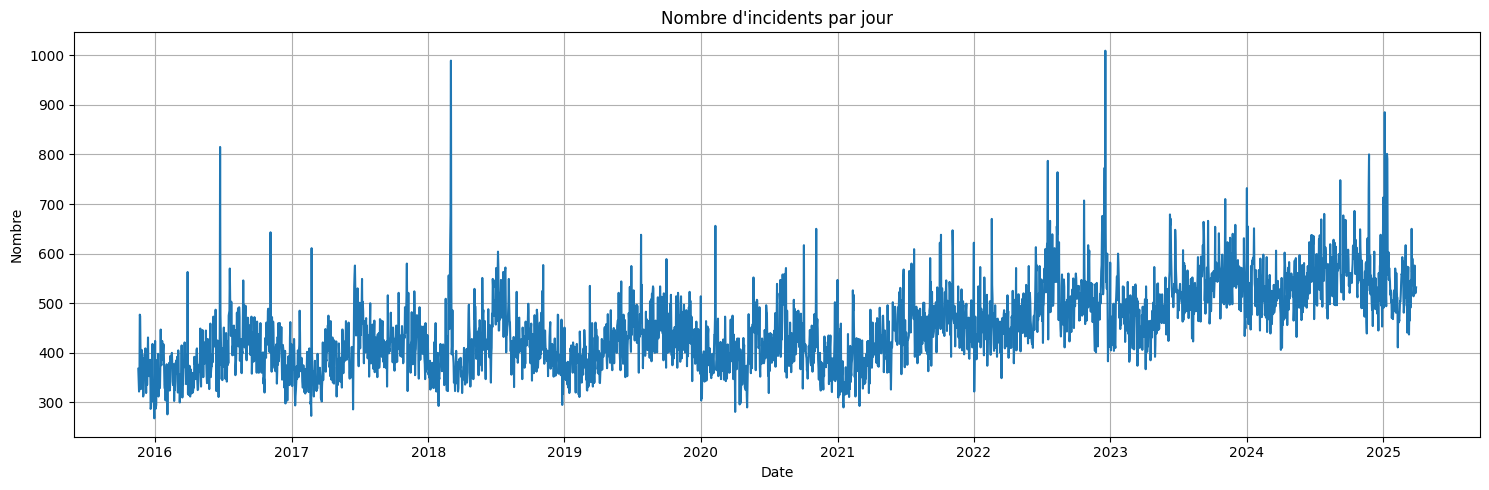

In [20]:
# Index temps
df['Date'] = df['DateAndTimeMobilised'].dt.date

# Incidents par jour
df_daily = df.groupby('Date').size()
plt.figure(figsize=(15,5))
df_daily.plot()
plt.title("Nombre d'incidents par jour")
plt.xlabel("Date")
plt.ylabel("Nombre")
plt.grid(True)
plt.tight_layout()
plt.show()

Ce qu’on observe :
Tendance générale à la hausse du nombre d’incidents de 2016 à 2025.

Pics très marqués à certaines dates (notamment en 2018 et 2023) — à explorer !

Un certain rythme saisonnier visible (oscillations régulières).

Peu ou pas de rupture nette, ce qui est bon pour des modèles de séries temporelles classiques

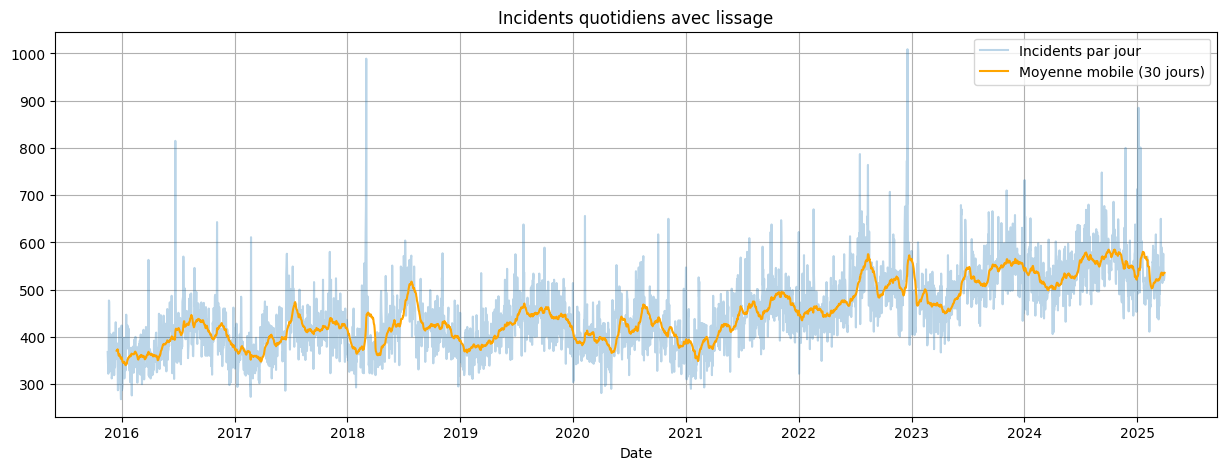

In [21]:
#1. Lissage de la saisonnalité annuelle
df_daily_smooth = df_daily.rolling(window=30).mean()

plt.figure(figsize=(15,5))
df_daily.plot(alpha=0.3, label='Incidents par jour')
df_daily_smooth.plot(label='Moyenne mobile (30 jours)', color='orange')
plt.title("Incidents quotidiens avec lissage")
plt.legend()
plt.grid(True)
plt.show()

C:\Users\9609241C\AppData\Local\Temp\ipykernel_32908\1524428541.py:8: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df_timeindex.resample('M').size().rename("Nombre d'incidents par mois")


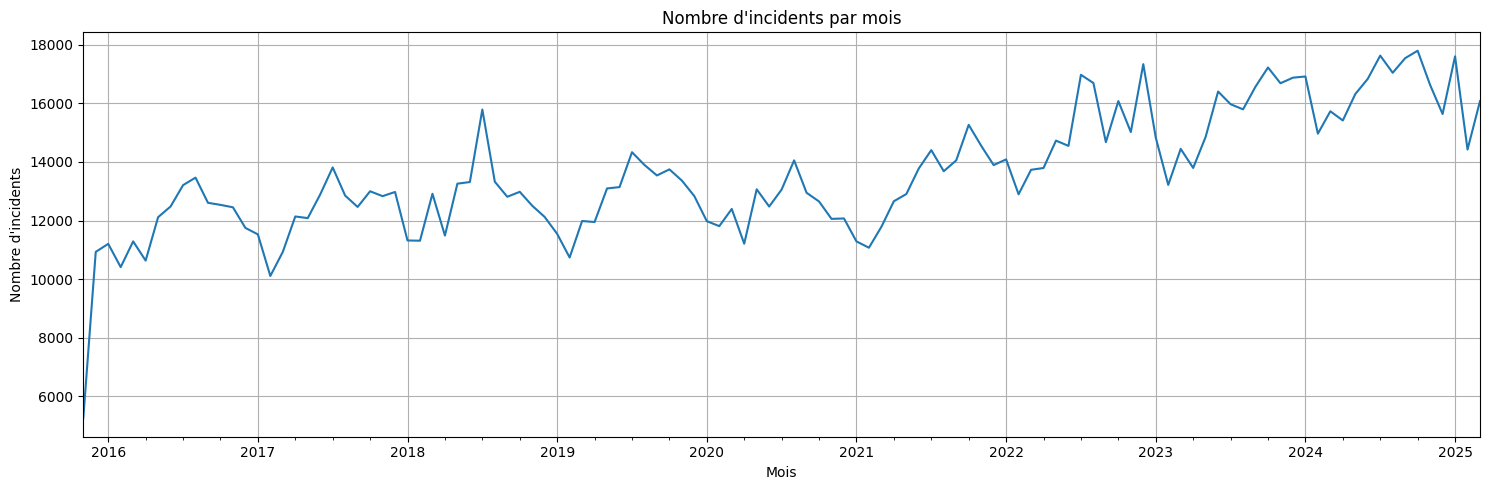

In [22]:
# 2. Agrégation mensuelle :

# Création d'une copie avec index datetime
df_timeindex = df.copy()
df_timeindex.set_index('DateAndTimeMobilised', inplace=True)

# Agrégation mensuelle sur la copie
monthly_counts = df_timeindex.resample('M').size().rename("Nombre d'incidents par mois")

plt.figure(figsize=(15,5))
monthly_counts.plot()
plt.title("Nombre d'incidents par mois")
plt.xlabel("Mois")
plt.ylabel("Nombre d'incidents")
plt.grid(True)
plt.tight_layout()
plt.show()

1. Tendance générale à la hausse
De 2016 à 2025, le nombre total d'incidents mensuels augmente progressivement !

2. Saisonnalité annuelle claire
On observe des creux et des pics réguliers chaque année, ce qui suggère une saisonnalité!
* certaines années montrent un pic autour de l’hiver ou du début d’année, suivi d’un creux en été ou fin d’année. Il faudrait une analyse plus précise (ex : moyenne par mois de l'année) pour confirmer.

3.  Pics anormaux ponctuels
Certains mois sortent du lot avec un niveau d’incidents très supérieur (ex. vers mi-2018, mi-2022, début 2023).
Ces valeurs aberrantes peuvent être liées à :
Un événement exceptionnel 
Un problème de qualité de données (doublons, sur-enregistrement…).

4. Petits creux inattendus
Par exemple début 2018 ou mi-2020, avec une chute visible.
Ça peut correspondre à des périodes de vacances, de confinement (COVID ?), ou ?



In [23]:
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538089 entries, 0 to 1538088
Data columns (total 61 columns):
 #   Column                                  Non-Null Count    Dtype          
---  ------                                  --------------    -----          
 0   IncidentNumber                          1538089 non-null  object         
 1   CalYear                                 1538089 non-null  int64          
 2   BoroughName                             773072 non-null   object         
 3   WardName                                772197 non-null   object         
 4   HourOfCall                              1538089 non-null  int64          
 5   ResourceMobilisationId                  1538089 non-null  int64          
 6   Resource_Code                           1538089 non-null  object         
 7   PerformanceReporting                    1538089 non-null  object         
 8   DateAndTimeMobilised                    1538089 non-null  datetime64[ns] 
 9   DateAndTimeMo

,IncidentNumber,CalYear,BoroughName,WardName,HourOfCall,ResourceMobilisationId,Resource_Code,PerformanceReporting,DateAndTimeMobilised,DateAndTimeMobile,DateAndTimeArrived,TurnoutTimeSeconds,TravelTimeSeconds,AttendanceTimeSeconds,DateAndTimeLeft,DateAndTimeReturned,DeployedFromStation_Code,DeployedFromStation_Name,DeployedFromLocation,PumpOrder,PlusCode_Code,PlusCode_Description,DelayCodeId,DelayCode_Description,DateOfCall,TimeOfCall,IncidentGroup,StopCodeDescription,SpecialServiceType,PropertyCategory,PropertyType,AddressQualifier,Postcode_full,Postcode_district,UPRN,USRN,IncGeo_BoroughCode,IncGeo_BoroughName,ProperCase,IncGeo_WardCode,IncGeo_WardName,IncGeo_WardNameNew,Easting_m,Northing_m,Easting_rounded,Northing_rounded,Latitude,Longitude,FRS,IncidentStationGround,FirstPumpArriving_AttendanceTime,FirstPumpArriving_DeployedFromStation,SecondPumpArriving_AttendanceTime,SecondPumpArriving_DeployedFromStation,NumStationsWithPumpsAttending,NumPumpsAttending,PumpCount,PumpMinutesRounded,Notional Cost (£),NumCalls,Date
0,000004-01012021,2021,HARINGEY,Muswell Hill,0,5769249,A321,1,2021-01-01 00:06:00,2021-01-01 00:07:00,2021-01-01 00:09:00,48.0,133.0,181,2021-01-01 00:57:00,NaT,A32,Hornsey,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,2021-01-01,0 days 00:06:47,False Alarm,AFA,NaN,Non Residential,Single shop,Correct incident location,N10 3RU,N10,1.000210e+11,21106387.0,E09000014,HARINGEY,Haringey,E05013594,Muswell Hill,Muswell Hill,528726.0,189566.0,528750,189550,51.590253,-0.143174,London,Hornsey,181.0,Hornsey,NaN,NaN,1.0,1.0,1,60,346,1.0,2021-01-01
1,000005-01012021,2021,REDBRIDGE,MONKHAMS,0,5769250,F351,1,2021-01-01 00:07:00,2021-01-01 00:09:00,2021-01-01 00:11:00,114.0,136.0,250,2021-01-01 00:18:00,NaT,F35,Woodford,Home Station,1,Initial,Initial Mobilisation,NaN,NaN,2021-01-01,0 days 00:07:46,Fire,Secondary Fire,NaN,Outdoor,Tree scrub,Open land/water - nearest gazetteer location,IG8 0EG,IG8,1.000230e+11,22304992.0,E09000026,REDBRIDGE,Redbridge,E05011249,MONKHAMS,MONKHAMS,540703.0,191739.0,540750,191750,51.606923,0.030486,London,Woodford,250.0,Woodford,NaN,NaN,1.0,1.0,1,60,346,1.0,2021-01-01
2,000006-01012021,2021,BARKING AND DAGENHAM,Village,0,5769251,F412,1,2021-01-01 00:08:00,2021-01-01 00:10:00,2021-01-01 00:14:00,131.0,245.0,376,2021-01-01 00:24:00,NaT,F41,Dagenham,Home Station,1,Initial,Initial Mobilisation,12.0,Not held up,2021-01-01,0 days 00:08:21,False Alarm,False alarm - Good intent,NaN,Outdoor,Road surface/pavement,In street close to gazetteer location,RM10 9RL,RM10,1.000538e+08,19900653.0,E09000002,BARKING AND DAGENHAM,Barking And dagenham,E05014070,Village,Village,549510.0,184560.0,549550,184550,51.540145,0.154515,London,Dagenham,376.0,Dagenham,NaN,NaN,1.0,1.0,1,60,346,1.0,2021-01-01
3,000007-01012021,2021,WANDSWORTH,West Hill,0,5769252,H331,1,2021-01-01 00:12:00,2021-01-01 00:13:00,2021-01-01 00:19:00,53.0,356.0,409,2021-01-01 00:40:00,NaT,H33,Wandsworth,Home Station,1,Initial,Initial Mobilisation,8.0,Traffic calming measures,2021-01-01,0 days 00:12:16,False Alarm,False alarm - Good intent,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,SW19,0.000000e+00,22904755.0,E09000032,WANDSWORTH,Wandsworth,E05014029,West Hill,West Hill,NaN,NaN,524150,173450,NaN,NaN,London,Wandsworth,409.0,Wandsworth,445.0,Fulham,5.0,5.0,5,99,571,4.0,2021-01-01
4,000007-01012021,2021,WANDSWORTH,West Hill,0,5769253,G351,2,2021-01-01 00:12:00,2021-01-01 00:13:00,2021-01-01 00:19:00,69.0,376.0,445,2021-01-01 00:29:00,NaT,G35,Fulham,Home Station,2,Initial,Initial Mobilisation,NaN,NaN,2021-01-01,0 days 00:12:16,False Alarm,False alarm - Good intent,NaN,Dwelling,Purpose Built Flats/Maisonettes - 4 to 9 storeys,Correct incident location,NaN,SW19,0.000000e+00,22904755.0,E09000032,WANDSWORTH,Wandsworth,E05014029,West Hill,West Hill,NaN,NaN,524150,173450,NaN,NaN,London,Wandsworth,409.0,Wandsworth,445.0,Fulham,5.0,5.0,5,99,571,4.0,2021-01-01


In [24]:
print(df.columns.tolist())

['IncidentNumber', 'CalYear', 'BoroughName', 'WardName', 'HourOfCall', 'ResourceMobilisationId', 'Resource_Code', 'PerformanceReporting', 'DateAndTimeMobilised', 'DateAndTimeMobile', 'DateAndTimeArrived', 'TurnoutTimeSeconds', 'TravelTimeSeconds', 'AttendanceTimeSeconds', 'DateAndTimeLeft', 'DateAndTimeReturned', 'DeployedFromStation_Code', 'DeployedFromStation_Name', 'DeployedFromLocation', 'PumpOrder', 'PlusCode_Code', 'PlusCode_Description', 'DelayCodeId', 'DelayCode_Description', 'DateOfCall', 'TimeOfCall', 'IncidentGroup', 'StopCodeDescription', 'SpecialServiceType', 'PropertyCategory', 'PropertyType', 'AddressQualifier', 'Postcode_full', 'Postcode_district', 'UPRN', 'USRN', 'IncGeo_BoroughCode', 'IncGeo_BoroughName', 'ProperCase', 'IncGeo_WardCode', 'IncGeo_WardName', 'IncGeo_WardNameNew', 'Easting_m', 'Northing_m', 'Easting_rounded', 'Northing_rounded', 'Latitude', 'Longitude', 'FRS', 'IncidentStationGround', 'FirstPumpArriving_AttendanceTime', 'FirstPumpArriving_DeployedFromSta

In [25]:
#valeurs manquantes
df.isnull().mean().sort_values(ascending=False)

DateAndTimeReturned              0.999997
SpecialServiceType               0.769749
DelayCodeId                      0.757824
DelayCode_Description            0.757824
Postcode_full                    0.595376
                                   ...   
NumStationsWithPumpsAttending    0.000000
PumpCount                        0.000000
PumpMinutesRounded               0.000000
Notional Cost (£)                0.000000
Date                             0.000000
Length: 61, dtype: float64

In [26]:
#Création de variables temporelles dérivées utiles 
df['duree_mobilisation'] = (df['DateAndTimeMobile'] - df['DateAndTimeMobilised']).dt.total_seconds() / 60
df['duree_deplacement'] = (df['DateAndTimeArrived'] - df['DateAndTimeMobile']).dt.total_seconds() / 60
df['duree_sur_place'] = (df['DateAndTimeLeft'] - df['DateAndTimeArrived']).dt.total_seconds() / 60
df['duree_totale'] = (df['DateAndTimeLeft'] - df['DateAndTimeMobilised']).dt.total_seconds() / 60

In [27]:
# Variables temporelles pour l’analyse
df['jour_semaine'] = df['DateOfCall'].dt.day_name()
df['mois'] = df['DateOfCall'].dt.month_name()
df['heure_appel'] = (df['TimeOfCall'].dt.total_seconds() / 3600).round().astype(int)

In [28]:
# Statistiques descriptives des durées en minutes
df[['duree_mobilisation', 'duree_deplacement', 'duree_sur_place', 'duree_totale']].describe()

,duree_mobilisation,duree_deplacement,duree_sur_place,duree_totale
count,1.528680e+06,1.528680e+06,1.537457e+06,1.537457e+06
mean,1.243786e+00,4.667979e+00,1.793698e+01,2.382729e+01
std,7.324642e-01,2.480790e+00,2.830292e+01,2.838794e+01
min,0.000000e+00,-9.316667e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,3.000000e+00,5.000000e+00,1.080000e+01
50%,1.000000e+00,4.083333e+00,9.566667e+00,1.550000e+01
75%,1.583333e+00,6.000000e+00,1.900000e+01,2.500000e+01
max,2.000000e+01,2.000000e+01,2.105983e+03,2.119300e+03


le min de la duree de deplcament est en negatif ? pas de sens !

duree_mobilisation	Moyenne ~1.24 min, médiane 1 min, max 20 min. La mobilisation est en général rapide et très concentrée.
duree_deplacement	Moyenne ~4.67 min, mais min négatif à -9.31 min (ce qui est anormal, à vérifier). Médiane 4.08 min, max 20 min.
duree_sur_place	Moyenne ~17.9 min, mais max très élevée (2105 min ~35 heures !), probablement des outliers ou erreurs.
duree_totale	Moyenne ~23.8 min, max aussi très élevée (2119 min), cohérent avec la durée sur place.

In [29]:
# valeurs negatives des durees de déplacement 
negatives = df[df['duree_deplacement'] < 0]
print(f"Nombre de valeurs négatives dans duree_deplacement : {len(negatives)}")
print(negatives.head())


Nombre de valeurs négatives dans duree_deplacement : 80
         IncidentNumber  CalYear BoroughName WardName  HourOfCall  \
969288  104269-02082017     2017         NaN      NaN          11   
970107  105236-04082017     2017         NaN      NaN          10   
973114  108460-11082017     2017         NaN      NaN          10   
979266  115360-26082017     2017         NaN      NaN          16   
992656  130441-27092017     2017         NaN      NaN          16   

        ResourceMobilisationId Resource_Code PerformanceReporting  \
969288                 4960335          E391                    1   
970107                 4961545          A412                    1   
973114                 4965739          G241                    1   
979266                 4974972          H322                    1   
992656                 4995388          H352                    1   

       DateAndTimeMobilised   DateAndTimeMobile  DateAndTimeArrived  \
969288  2017-08-02 10:09:43 2017-08-02 10:1

DateAndTimeArrived < DateAndTimeMobile
==> Ce qui explique la durée négative.

les valeurs negatives et abberantes suivantes seraient pottentiellement complexe a nettoyer meme si infime par rapport à tout le data set !
supprimer les 80 valeurs ! ==> negligeable face à la volumétrie des données

<span style="color:#e91e63; font-size:1em; font-weight:bold;">7. Exploration temporelle — vers une analyse en série temporelle </span>

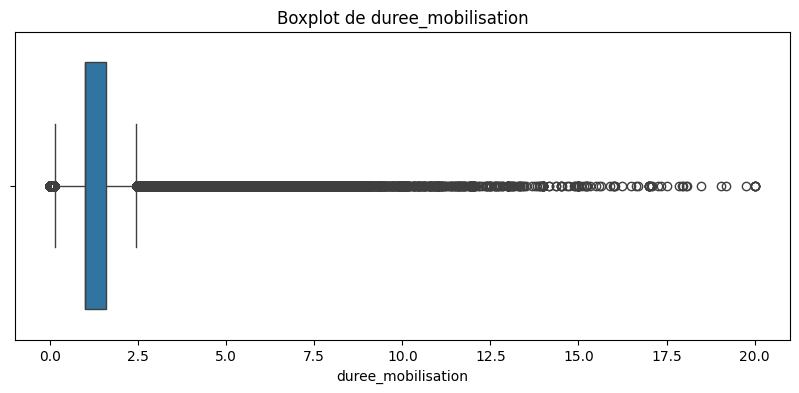

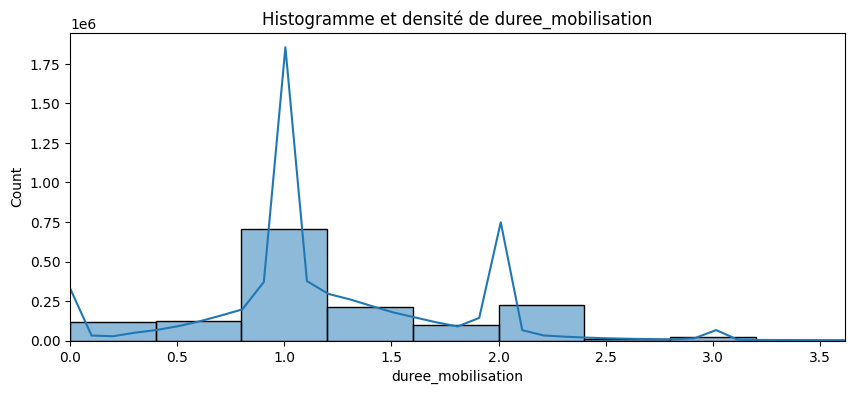

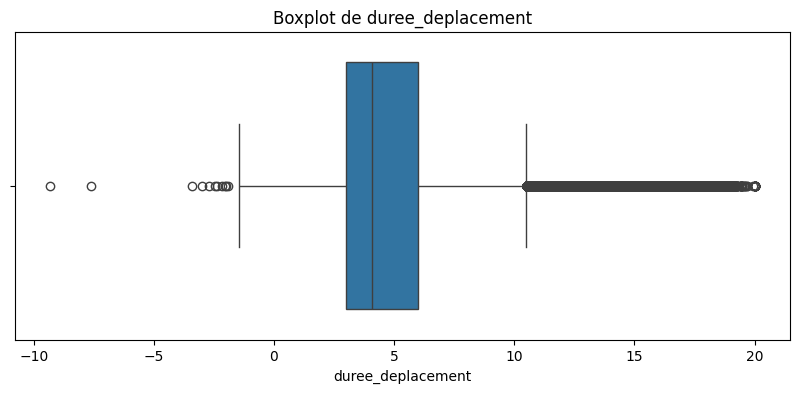

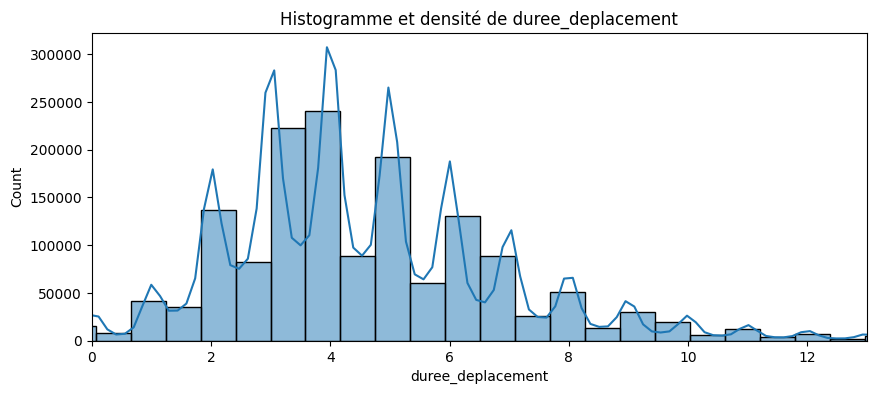

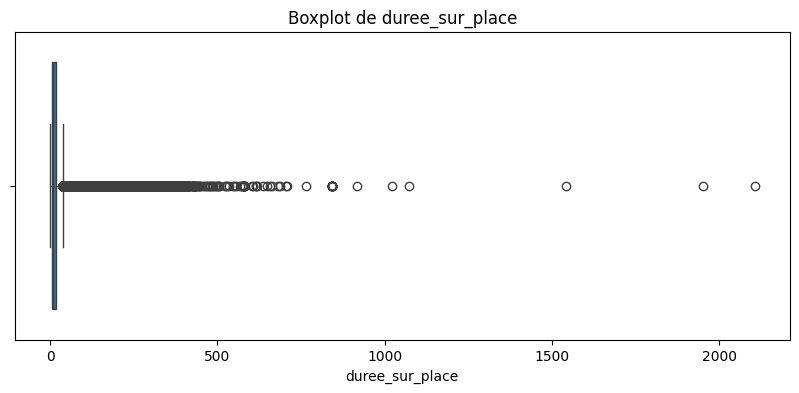

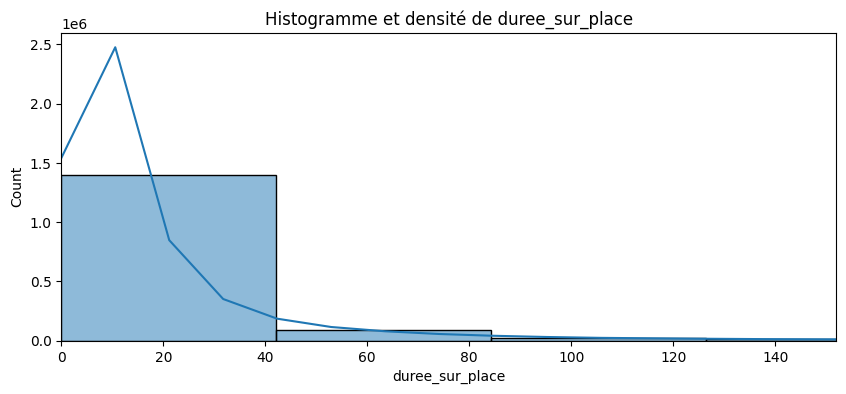

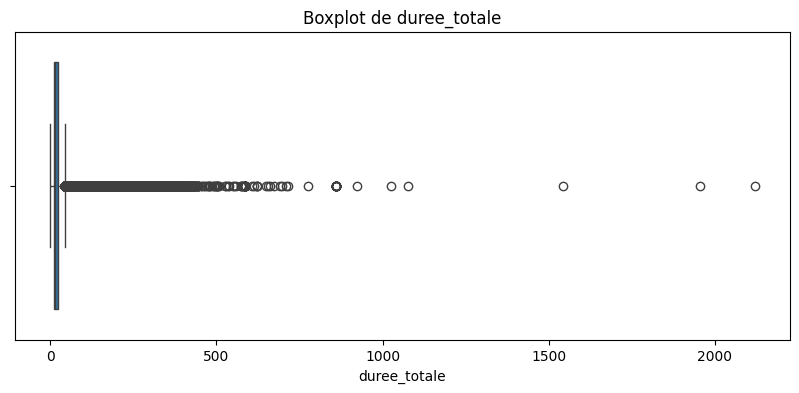

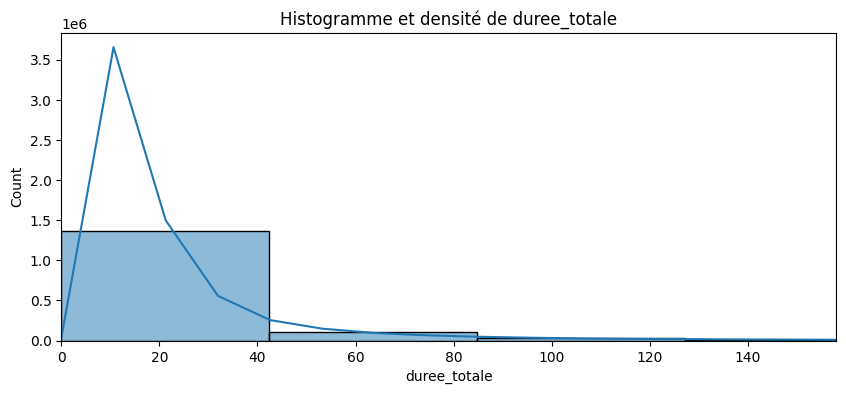

In [30]:
cols = ['duree_mobilisation', 'duree_deplacement', 'duree_sur_place', 'duree_totale']

for col in cols:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot de {col}")
    plt.show()

    plt.figure(figsize=(10,4))
    sns.histplot(df[col], bins=50, kde=True)
    plt.title(f"Histogramme et densité de {col}")
    plt.xlim(0, df[col].quantile(0.99))  
    plt.show()


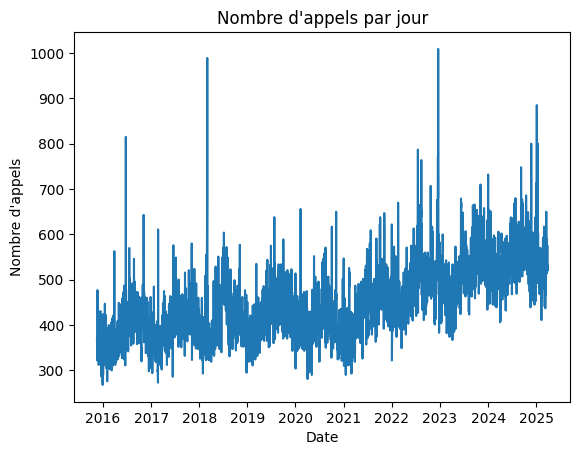

In [31]:

# Determiner le nombre d'appels, il faut d'abord sommer la colonne 'NumCalls' (qui représente le nombre d'appels pour chaque ligne)
daily_counts = df.groupby('Date')['NumCalls'].sum().reset_index(name='nb_appels')  

# Regroupement par jour en comptant le nombre d'incidents
daily_counts = df.groupby('Date').size().reset_index(name='nb_appels')

# Visualisation rapide
import matplotlib.pyplot as plt
plt.plot(daily_counts['Date'], daily_counts['nb_appels'])
plt.title('Nombre d\'appels par jour')
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.show()

* L'allure semble identique à celle du nb d'incident jour classique ! ==> Il y a autant d'appels que d'incidents

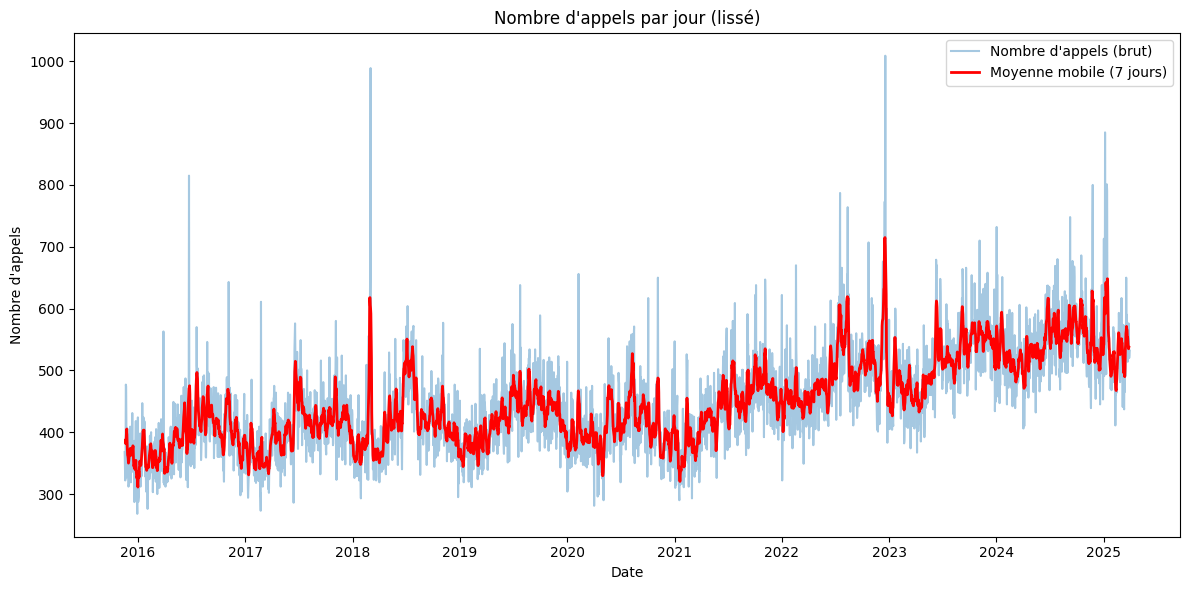

In [32]:
# Lissage avec une moyenne mobile sur 7 jours
daily_counts['nb_appels_smooth'] = daily_counts['nb_appels'].rolling(window=7, center=True).mean()

# Tracé
plt.figure(figsize=(12,6))
plt.plot(daily_counts['Date'], daily_counts['nb_appels'], label='Nombre d\'appels (brut)', alpha=0.4)
plt.plot(daily_counts['Date'], daily_counts['nb_appels_smooth'], label='Moyenne mobile (7 jours)', color='red', linewidth=2)
plt.title('Nombre d\'appels par jour (lissé)')
plt.xlabel('Date')
plt.ylabel('Nombre d\'appels')
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# Extraire la date  — pour une granularité journalière du nombre d'appels
df['Date'] = df['DateOfCall'].dt.floor('D')

# Calcul du nombre d'appels par jour
target_series = df.groupby('Date').size().reset_index(name='nb_appels')

# 'nb_appels' est la variable cible à prédire
print(target_series.head())


        Date  nb_appels
0 2015-11-16          1
1 2015-11-17        368
2 2015-11-18        342
3 2015-11-19        322
4 2015-11-20        331


C:\Users\9609241C\AppData\Local\Temp\ipykernel_32908\1636848269.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date_heure'] = df['date_heure'].dt.floor('H')


            date_heure  nb_appels  nb_appels_smooth
0  2015-11-16 10:00:00          1               NaN
1  2015-11-17 02:00:00          5               3.0
2  2015-11-17 03:00:00          4               4.5
3  2015-11-17 04:00:00          4               4.0
4  2015-11-17 05:00:00          6               5.0
5  2015-11-17 06:00:00          5               5.5
6  2015-11-17 07:00:00         11               8.0
7  2015-11-17 08:00:00         18              14.5
8  2015-11-17 09:00:00         24              21.0
9  2015-11-17 10:00:00          9              16.5
10 2015-11-17 11:00:00         13              11.0
11 2015-11-17 12:00:00          8              10.5
12 2015-11-17 13:00:00         15              11.5
13 2015-11-17 14:00:00         20              17.5
14 2015-11-17 15:00:00          9              14.5


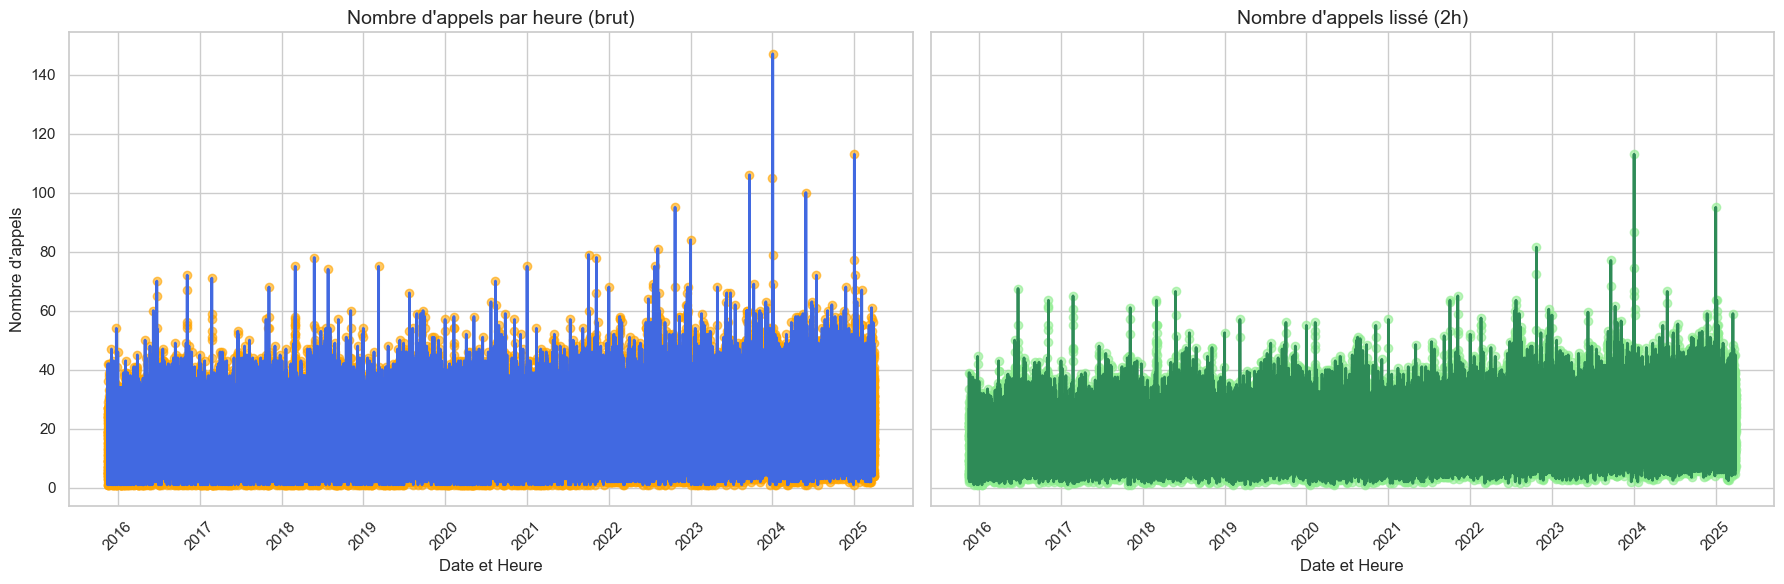

In [47]:
# Fusion des colonnes DateOfCall et TimeOfCall en datetime
df['date_heure'] = pd.to_datetime(df['DateOfCall']  + df['TimeOfCall'], errors='coerce')

# Arrondir à l'heure la plus proche
df['date_heure'] = df['date_heure'].dt.floor('H')

# Calculer le nombre d'appels par heure
target_series = df.groupby('date_heure').size().reset_index(name='nb_appels')

sns.set(style='whitegrid')
# Calculer une moyenne mobile sur 2 heures
target_series['nb_appels_smooth'] = target_series['nb_appels'].rolling(window=2, center=True).mean()

# Affichage des 20 premières lignes
print(target_series.head(15))

# Création des deux sous-graphiques côte à côte
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# --- Graphique 1 : données brutes ---
axs[0].plot(target_series['date_heure'], target_series['nb_appels'], label='Nb appels', color='royalblue', linewidth=2)
axs[0].scatter(target_series['date_heure'], target_series['nb_appels'], color='orange', alpha=0.6)
axs[0].set_title('Nombre d\'appels par heure (brut)', fontsize=14)
axs[0].set_xlabel('Date et Heure')
axs[0].set_ylabel('Nombre d\'appels')
axs[0].tick_params(axis='x', rotation=45)

# --- Graphique 2 : données lissées (2h) ---
axs[1].plot(target_series['date_heure'], target_series['nb_appels_smooth'], label='Lissage (2h)', color='seagreen', linewidth=2)
axs[1].scatter(target_series['date_heure'], target_series['nb_appels_smooth'], color='lightgreen', alpha=0.6)
axs[1].set_title('Nombre d\'appels lissé (2h)', fontsize=14)
axs[1].set_xlabel('Date et Heure')
axs[1].tick_params(axis='x', rotation=45)

# Mise en page
plt.tight_layout()
plt.show()

In [ ]:
# Extraire la date  — pour une granularité journalière du nombre d'incidents
df['date'] = df['DateAndTimeMobilised'].dt.floor('D')

# Calcul du nombre d'incidents par jour
target_series = df.groupby('date').size().reset_index(name='nb_incidents')

# 'nb_incidents' est la variable cible à prédire
print(target_series.head())


        date  nb_incidents
0 2015-11-17           368
1 2015-11-18           342
2 2015-11-19           322
3 2015-11-20           330
4 2015-11-21           477


C:\Users\9609241C\AppData\Local\Temp\ipykernel_32908\1301260629.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['date_heure'] = df['DateAndTimeMobilised'].dt.floor('H')


            date_heure  nb_incidents
0  2015-11-17 02:00:00             5
1  2015-11-17 03:00:00             4
2  2015-11-17 04:00:00             4
3  2015-11-17 05:00:00             6
4  2015-11-17 06:00:00             5
5  2015-11-17 07:00:00            10
6  2015-11-17 08:00:00            19
7  2015-11-17 09:00:00            24
8  2015-11-17 10:00:00             9
9  2015-11-17 11:00:00            13
10 2015-11-17 12:00:00             8
11 2015-11-17 13:00:00            15
12 2015-11-17 14:00:00            20
13 2015-11-17 15:00:00             9
14 2015-11-17 16:00:00            26


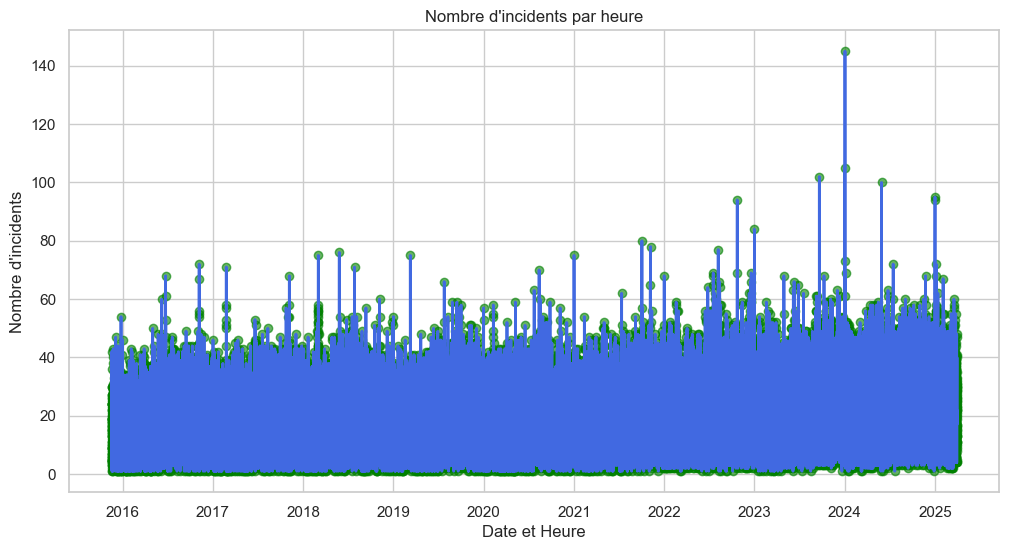

In [50]:
# Extraire la date heure — pour une granularité par heure dans la journée du nombre d'incidents
df['date_heure'] = df['DateAndTimeMobilised'].dt.floor('H')

# Calculer le nombre d'incidents par heure
target_series = df.groupby('date_heure').size().reset_index(name='nb_incidents')

# 'nb_incidents' est la variable cible à prédire
print(target_series.head(15))
# Visualisation du nombre d'incidents par heure
plt.figure(figsize=(12,6))
plt.plot(target_series['date_heure'], target_series['nb_incidents'],label='Nb appels', color='royalblue', linewidth=2)
plt.scatter(target_series['date_heure'], target_series['nb_incidents'], color='green', alpha=0.6)
plt.title('Nombre d\'incidents par heure')
plt.xlabel('Date et Heure')
plt.ylabel('Nombre d\'incidents')
plt.show()


<span style="color:#39c498; font-size:1em; font-weight:bold;"> Les données du dataset "temporelles" semblent etre de bon candidats pour répondre à la problématique suivante : Prédire la durée totale d’intervention (duree_totale) de la brigade des pompiers pour un futur incident ! </span>

In [56]:
df_jointure = df.copy()
# Sauvegarde du DataFrame final
output_path = os.path.join(base_path, "data", "raw", "Processed", "df_processed.csv") 
df_jointure.to_csv(output_path, index=False)
print(f"\nDataFrame final sauvegardé dans : {output_path}")



DataFrame final sauvegardé dans : c:\Users\9609241C\london-fire-response\data\raw\Processed\df_processed.csv


In [61]:
min_date = df_jointure['CalYear'].min()
max_date = df_jointure['CalYear'].max()
print(f"\nPériode couverte par les données : {min_date} à {max_date}")


Période couverte par les données : 2015 à 2025
